# Random Forest with engineered features

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

In [117]:
pd.options.display.max_rows = 170 # For debugging, can be removed later
RSEED = 420

## Loading the data from 02_feature_engineering

In [3]:
data_subsets_features = pickle.load(open('data_subsets_features.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
iq_train_train, \
iq_train_test = data_subsets_features

## Wisorizing (seeing the actual test data --> bad idea!)

In [4]:
# def winsorizer(df, colname, clip_upper, time_ratio=0.5):
#     '''
#     Inputs:
#     df: dataframe
#     colname: name of the variable to be winsorised
#     clip_upper: where to clip the values in proportion to the global maximum,
#     e.g. 0.8 => clip the values above 80% of the global maximum of the variable
#     ratio: what portion of the series should be winsorised, 
#     e.g. 0.3 => the first third of the series is modified.
#     Output: the dataframe with one modified variable
#     '''
#     early = df.iloc[:round(df.shape[0]/(1/time_ratio)),:]
#     late = df.iloc[round(df.shape[0]/(1/time_ratio)):,:]
#     clipped_var = early[colname].clip(upper=max(df[colname])*clip_upper)
#     df[colname] = pd.concat([clipped_var, late[colname]])
#     return df

In [5]:
# sj_train_train = winsorizer(sj_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)
# iq_train_train = winsorizer(iq_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)

## Adding lags

In [6]:
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [7]:
def get_lagged_dataframe(df, features, max_lag):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags (defined by max_lag) start at 0, which is the original feature (without shift).
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    max_lag: number of maximum lags
    
    """
    d = {}
    for feature in features:
        for lag in range(max_lag+1):
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

In [8]:
sj_train_train_lags = get_lagged_dataframe(sj_train_train, env_cols(sj_train_train), 8)
sj_train_test_lags = get_lagged_dataframe(sj_train_test, env_cols(sj_train_test), 8)

In [9]:
iq_train_train_lags = get_lagged_dataframe(iq_train_train, env_cols(iq_train_train), 8)
iq_train_test_lags = get_lagged_dataframe(iq_train_test, env_cols(iq_train_test), 8)

In [10]:
def join_basics_with_lags(df, df_lags):
    df = df.join(df_lags)
    df = df[df.columns.drop(list(df.filter(regex='lag0')))]
    return df

In [11]:
sj_train_train = join_basics_with_lags(sj_train_train, sj_train_train_lags)
sj_train_test = join_basics_with_lags(sj_train_test, sj_train_test_lags)

In [12]:
iq_train_train = join_basics_with_lags(iq_train_train, iq_train_train_lags)
iq_train_test = join_basics_with_lags(iq_train_test, iq_train_test_lags)

In [13]:
data_subsets_w_lags = [sj_train_train, sj_train_test, iq_train_train, iq_train_test]
# save the data subsets in a pickle
pickle.dump(data_subsets_w_lags, open('train_w_lags.pickle', 'wb'))

## Start here for modelling

In [57]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [58]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [59]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

In [60]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [61]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [62]:
sj_train_train, \
sj_train_test, \
iq_train_train, \
iq_train_test = pickle.load(open('train_w_lags.pickle', 'rb'))

## Feature selection

In [63]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(7)
    .index
)

## Preprocessing for Sklearn

In [64]:
def custom_dropper(df, cols):
    '''
    drops rows with NaNs from a dataframe based on their presence in a subset of the df
    '''
    return df[df.index.isin(df[cols].dropna().index)]
# custom_dropper(sj_train_train, my_features)

In [65]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

## Scaling

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

## Regression (Random Forest)

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
from sklearn.model_selection import GridSearchCV

In [440]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 100],
    'max_depth': [1, 3, 10],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [7, 10, 15, 20],
#     'bootstrap': [True, False],
    'min_samples_split': [3, 5, 7]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
#                   scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

# Fit 
gs.fit(X_train, y_train)
gs.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'max_depth': 3,
 'max_leaf_nodes': 20,
 'min_samples_split': 3,
 'n_estimators': 10}

In [441]:
rf = gs.best_estimator_

In [71]:
rf = RandomForestRegressor(max_depth=10)

In [72]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [89]:
y_train_pred = np.exp(rf.predict(X_train))
y_train_pred = pd.Series(y_train_pred)
y_train_pred -= 1
y_train_pred.index = y_train.index

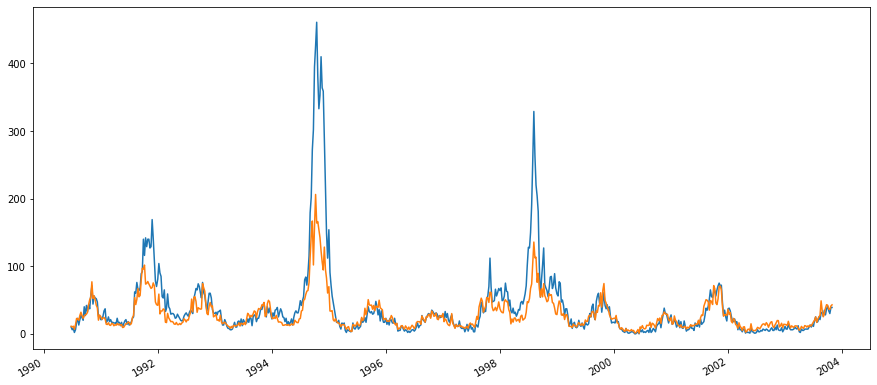

In [93]:
y_train = np.exp(y_train)
y_train -= 1
y_train.plot()
y_train_pred.plot();

In [94]:
y_test_pred = np.exp(rf.predict(X_test))
y_test_pred = pd.Series(y_test_pred)
y_test_pred -= 1
y_test_pred.index = y_test.index

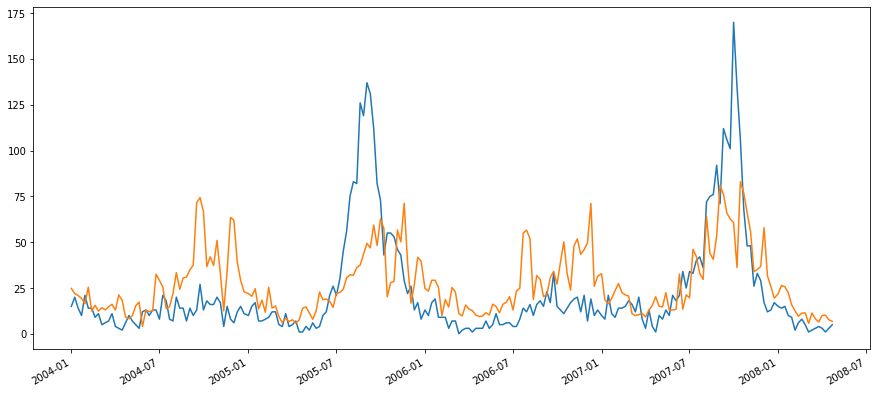

In [95]:
y_test = np.exp(y_test)
y_test -= 1
y_test.plot()
y_test_pred.plot();

In [96]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 24.15
--------------------
MAE: 16.46
Explained variance: 0.336
--------------------


## Smoothing

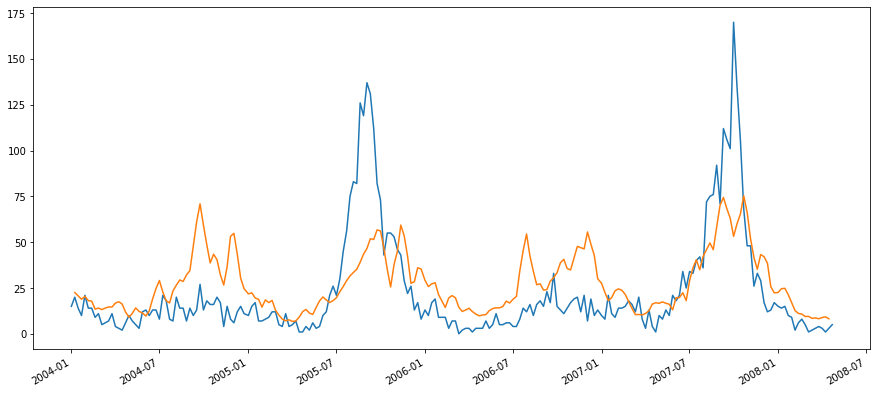

In [97]:
y_test.plot()
y_test_pred.rolling(window=3, center=True).mean().plot();

In [98]:
model_classification(y_test.iloc[1:-1], y_test_pred.rolling(window=3, center=True).mean().dropna())

--------------------
RMSE: 23.21
--------------------
MAE: 15.91
Explained variance: 0.393
--------------------


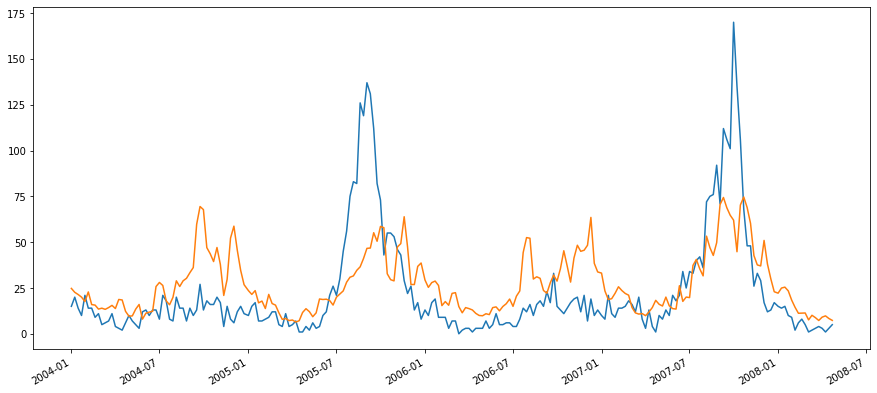

In [99]:
y_test.plot()
y_test_pred.ewm(span=2).mean().plot();

In [100]:
model_classification(y_test, y_test_pred.ewm(span=2).mean().dropna())

--------------------
RMSE: 23.66
--------------------
MAE: 16.31
Explained variance: 0.364
--------------------


# Poisson Regression

## Feature selection

In [101]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(10)
    .index
)

In [102]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

In [103]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
from sklearn import linear_model

In [105]:
clf = linear_model.PoissonRegressor(alpha=0.01, max_iter=1000)
clf.fit(X_train, y_train)

PoissonRegressor(alpha=0.01, max_iter=1000)

In [106]:
y_train_pred = clf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

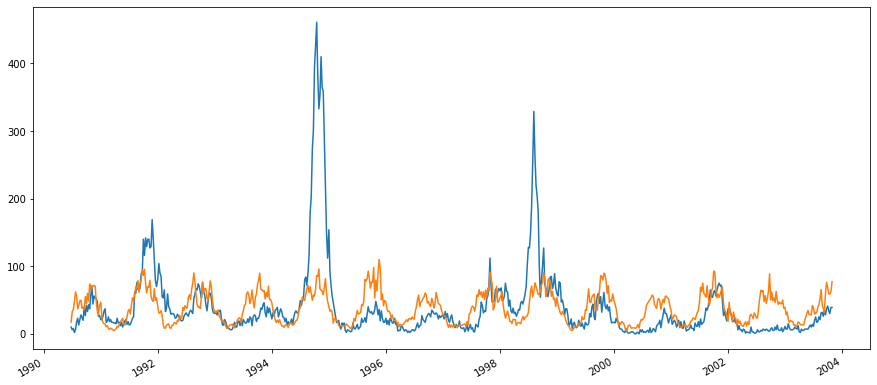

In [107]:
y_train.plot()
y_train_pred.plot();

In [108]:
y_test_pred = clf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

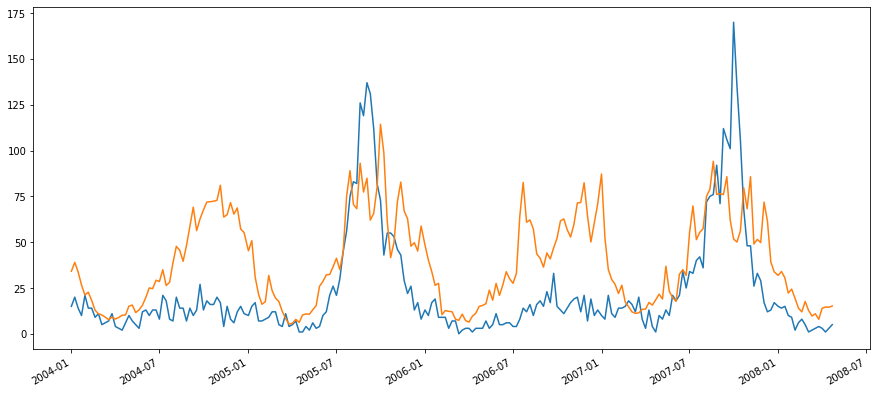

In [109]:
y_test.plot()
y_test_pred.plot();

In [110]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 30.02
--------------------
MAE: 22.73
Explained variance: 0.263
--------------------


# KNN Regression

## Feature selection

In [195]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(7)
    .index
)

In [196]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

In [197]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [198]:
from sklearn.neighbors import KNeighborsRegressor

In [208]:
knn = KNeighborsRegressor(n_neighbors=10, p=1)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10, p=1)

In [209]:
y_train_pred = knn.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

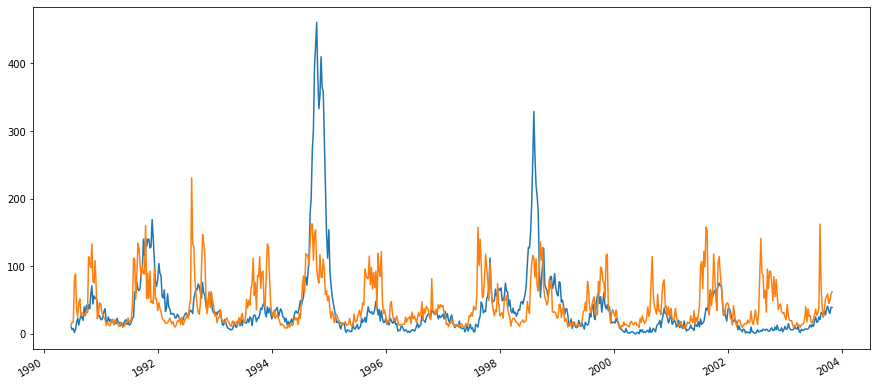

In [210]:
y_train.plot()
y_train_pred.plot();

In [211]:
y_test_pred = knn.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

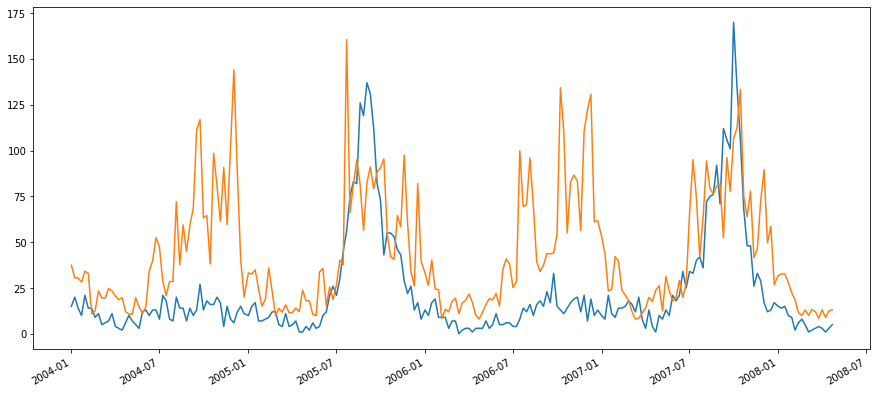

In [212]:
y_test.plot()
y_test_pred.plot();

In [213]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 36.61
--------------------
MAE: 25.82
Explained variance: -0.056
--------------------


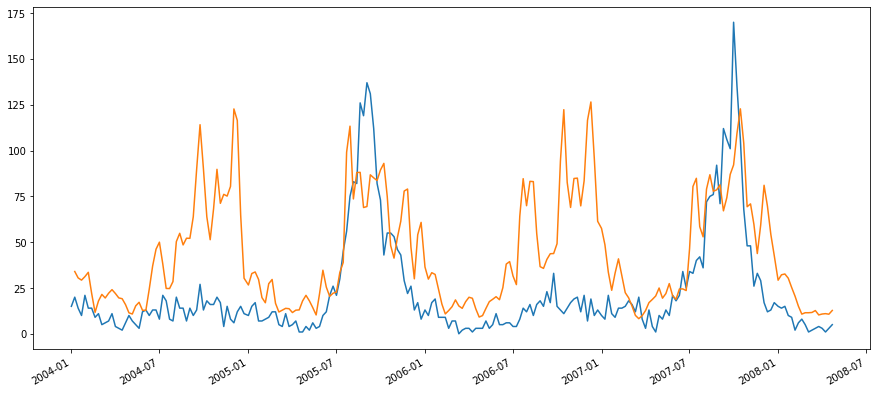

In [214]:
y_test.plot()
y_test_pred.rolling(window=2).mean().plot();

In [215]:
model_classification(y_test.iloc[1:], y_test_pred.rolling(window=2).mean().dropna())

--------------------
RMSE: 35.14
--------------------
MAE: 25.71
Explained variance: 0.075
--------------------


## Poisson Regression - Gradient Boosting

In [710]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

#     ("regressor", HistGradientBoostingRegressor(loss="poisson",
#                                                 max_leaf_nodes=128)),
# ])
# poisson_gbrt.fit(df_train, df_train["Frequency"],
#                  regressor__sample_weight=df_train["Exposure"])

# print("Poisson Gradient Boosted Trees evaluation:")
# score_estimator(poisson_gbrt, df_test)

### Feature selection

In [711]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(7)
    .index
)

In [712]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

In [713]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [724]:
gbrt = HistGradientBoostingRegressor(loss='poisson', 
                                     max_leaf_nodes=20,
                                     max_depth=20
                                     )
gbrt.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson', max_depth=20, max_leaf_nodes=20)

In [749]:
# Hyperparameter grid
param_grid = {
    'max_depth': [1,1.5, 2, 3],
    'max_leaf_nodes': [3, 5, 7, 6],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Estimator for use in random search
estimator = HistGradientBoostingRegressor(loss='poisson', max_iter=500, verbose=1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
                  scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1,
                 n_jobs=6)

# Fit 
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Binning 0.000 GB of training data: 0.003 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[2/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[3/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[4/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[5/500] 1 tree, 2 leaves, max depth = 1, in 0.002s
[6/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[7/500] 1 tree, 2 leaves, max depth = 1, in 0.002s
[8/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[9/500] 1 tree, 2 leaves, max depth = 1, in 0.002s
[10/500] Binning 0.000 GB of training data: 1 tree, 2 leaves, max depth = 1, in 0.002s
[11/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[12/500] 1 tree, 2 leaves, max depth = 1, in 0.002s
[13/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[14/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[15/500] 0.006 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 2 leaves, max depth = 1, in 0.001s
[2/500]

In [739]:
gbrt = gs.best_estimator_

In [740]:
y_train_pred = gbrt.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

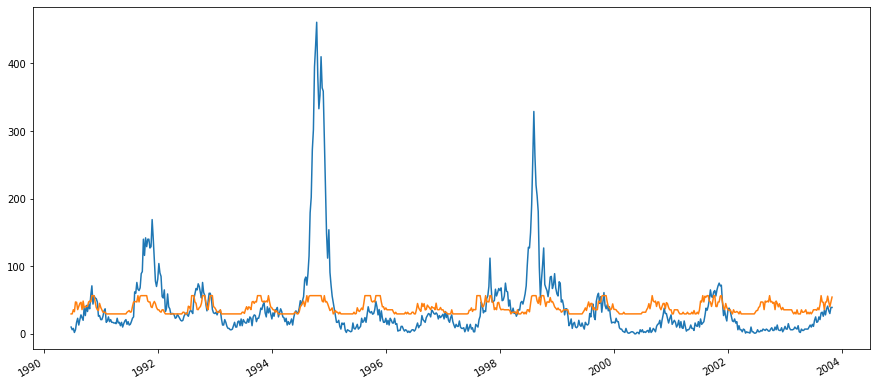

In [741]:
y_train.plot()
y_train_pred.plot();

In [742]:
y_test_pred = gbrt.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

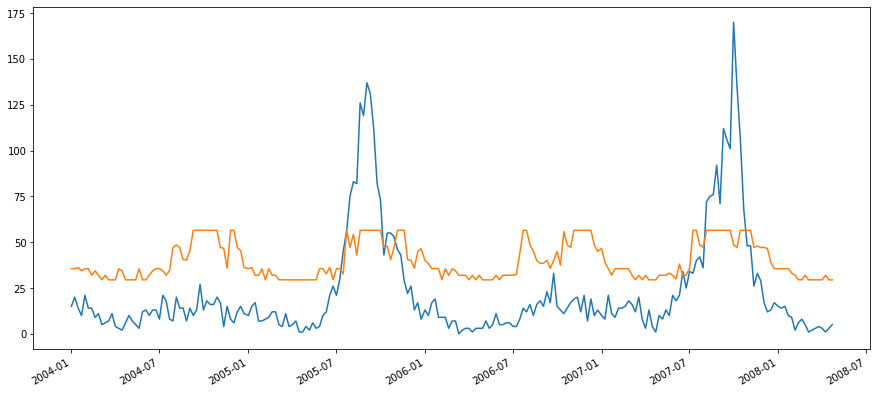

In [743]:
y_test.plot()
y_test_pred.plot();

In [734]:
y_hat = y_test_pred
y_hat -= 15

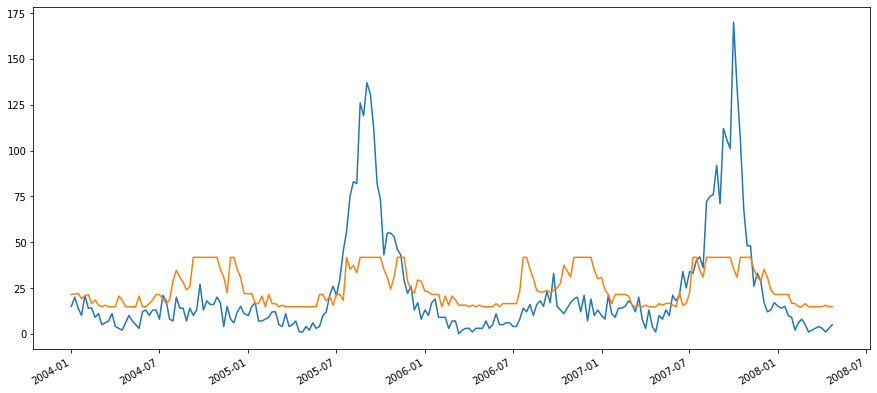

In [735]:
y_test.plot()
y_hat.plot();

In [723]:
model_classification(y_test, y_hat)

--------------------
RMSE: 24.53
--------------------
MAE: 16.35
Explained variance: 0.293
--------------------


## Facebook Prophet

In [392]:
from prophet import Prophet

In [393]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(7)
    .index
)

In [394]:
prophet_df = pd.DataFrame(sj_train_train.dropna().total_cases).reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = pd.concat([prophet_df, sj_train_train.dropna()[my_features].reset_index(drop=True)], axis=1)
# prophet_df['cap'] = 3 * prophet_df['y'].max()
prophet_df.head()

ds   y  reanalysis_min_air_temp_c_lag8  station_avg_temp_c_lag6  \
0 1990-07-30  17                           24.95                28.371429   
1 1990-08-06  23                           24.55                28.328571   
2 1990-08-13  13                           25.25                28.328571   
3 1990-08-20  21                           24.55                27.557143   
4 1990-08-27  28                           25.55                28.128571   

   station_min_temp_c_lag6  station_avg_temp_c_lag7  station_min_temp_c_lag7  \
0                     22.8                27.414286                     23.3   
1                     22.8                28.371429                     22.8   
2                     24.4                28.328571                     22.8   
3                     21.7                28.328571                     24.4   
4                     23.9                27.557143                     21.7   

   station_min_temp_c_lag8  station_avg_temp_c_lag8  
0                     23.9                28.114286  
1                     23.3                27.414286  
2                     22.8                28.371429  
3                     22.8                28.328571  
4                     24.4                28.328571

In [395]:
scaler = StandardScaler()
prophet_df.iloc[:,2:] = scaler.fit_transform(prophet_df.iloc[:,2:])
# X_test = scaler.transform(X_test)

In [396]:
m = Prophet(interval_width=0.95,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=0.1,
#             mcmc_samples=1000,
            likelihood='NegBinomial',
            growth='flat',
            yearly_seasonality=True)

In [397]:
for i in range(len(sj_train_train[my_features].columns)):
    m.add_regressor(sj_train_train[my_features].iloc[:,i].name)

In [398]:
# m.extra_regressors

In [399]:
model = m.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = 85140.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67         85295   6.27231e-05       1.74893      0.1949           1       83   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [400]:
sj_train = pd.concat([sj_train_train, sj_train_test])
sj_train = sj_train[my_features].dropna().reset_index()
sj_train = sj_train.rename(columns={'index': 'ds'})

sj_train.iloc[:,1:] = scaler.transform(sj_train.iloc[:,1:])
sj_train
# sj_train.ds.plot(style='.');

ds  reanalysis_min_air_temp_c_lag8  station_avg_temp_c_lag6  \
0   1990-06-25                       -1.051616                -0.237596   
1   1990-07-02                       -0.653342                 0.321715   
2   1990-07-09                        0.063551                 1.408679   
3   1990-07-16                       -0.175414                 0.796602   
4   1990-07-23                        0.222860                 0.279503   
..         ...                             ...                      ...   
915 2008-03-25                       -2.326093                -1.651705   
916 2008-04-01                       -1.449890                -1.577833   
917 2008-04-08                       -0.573688                -1.693917   
918 2008-04-15                       -0.653342                -1.419538   
919 2008-04-22                       -0.732997                -1.261242   

     station_min_temp_c_lag6  station_avg_temp_c_lag7  \
0                   0.145156                -0.236338   
1                   0.482389                -0.236338   
2                   0.887067                 0.323689   
3                   0.887067                 1.412043   
4                   0.482389                 0.799183   
..                       ...                      ...   
915                -1.001433                -2.085484   
916                -0.596754                -1.652256   
917                -1.001433                -1.578290   
918                -1.001433                -1.694522   
919                -0.259522                -1.419792   

     station_min_temp_c_lag7  station_min_temp_c_lag8  station_avg_temp_c_lag8  
0                  -0.258314                -1.746046                -1.176898  
1                   0.147077                -0.257588                -0.235839  
2                   0.484902                 0.148356                -0.235839  
3                   0.890293                 0.486642                 0.324567  
4                   0.890293                 0.892585                 1.413657  
..                       ...                      ...                      ...  
915                -1.001531                -1.746046                -1.821894  
916                -1.001531                -1.001817                -2.086236  
917                -0.596140                -1.001817                -1.652715  
918                -1.001531                -0.595874                -1.578699  
919                -1.001531                -1.001817                -1.695010  

[920 rows x 8 columns]

In [401]:
future = m.make_future_dataframe(periods=sj_train_test.shape[0],freq='W')
future =  future.dropna()
# future.plot(style='.');

In [402]:
forecast = m.predict(sj_train)
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
915 2008-03-25  37.136298         0.0      43.025    37.136298    37.136298   
916 2008-04-01  37.136298         0.0      55.000    37.136298    37.136298   
917 2008-04-08  37.136298         1.0      54.050    37.136298    37.136298   
918 2008-04-15  37.136298         0.0      51.000    37.136298    37.136298   
919 2008-04-22  37.136298         1.0      52.000    37.136298    37.136298   

     extra_regressors_multiplicative  extra_regressors_multiplicative_lower  \
915                        -0.712698                              -0.712698   
916                        -0.566722                              -0.566722   
917                        -0.496446                              -0.496446   
918                        -0.480232                              -0.480232   
919                        -0.433014                              -0.433014   

     extra_regressors_multiplicative_upper  multiplicative_terms  ...  \
915                              -0.712698             -0.675440  ...   
916                              -0.566722             -0.557832  ...   
917                              -0.496446             -0.539826  ...   
918                              -0.480232             -0.581082  ...   
919                              -0.433014             -0.584312  ...   

     station_min_temp_c_lag8  station_min_temp_c_lag8_lower  \
915                -0.064216                      -0.064216   
916                -0.036845                      -0.036845   
917                -0.036845                      -0.036845   
918                -0.021915                      -0.021915   
919                -0.036845                      -0.036845   

     station_min_temp_c_lag8_upper    yearly  yearly_lower  yearly_upper  \
915                      -0.064216  0.037259      0.037259      0.037259   
916                      -0.036845  0.008890      0.008890      0.008890   
917                      -0.036845 -0.043379     -0.043379     -0.043379   
918                      -0.021915 -0.100850     -0.100850     -0.100850   
919                      -0.036845 -0.151298     -0.151298     -0.151298   

     additive_terms  additive_terms_lower  additive_terms_upper       yhat  
915             0.0                   0.0                   0.0  12.378653  
916             0.0                   0.0                   0.0  16.549510  
917             0.0                   0.0                   0.0  17.200991  
918             0.0                   0.0                   0.0  15.712227  
919             0.0                   0.0                   0.0  15.596303  

[5 rows x 40 columns]

This `clips` the possible values, so that there are no negative values (we have count values as the target!!!)

In [403]:
# for col in ['yhat', 'yhat_lower', 'yhat_upper']:
#     forecast[col] = forecast[col].clip(lower=0.0)

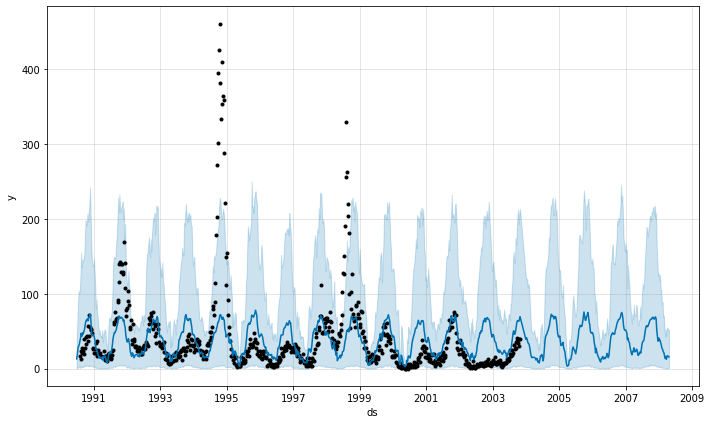

In [404]:
m.plot(forecast);

In [405]:
pred = pd.DataFrame(forecast[['yhat', 'ds']])
pred.index = pred.ds
pred = pred.drop('ds', axis=1)
pred = pred.loc[sj_train_test.dropna().index[0]:]

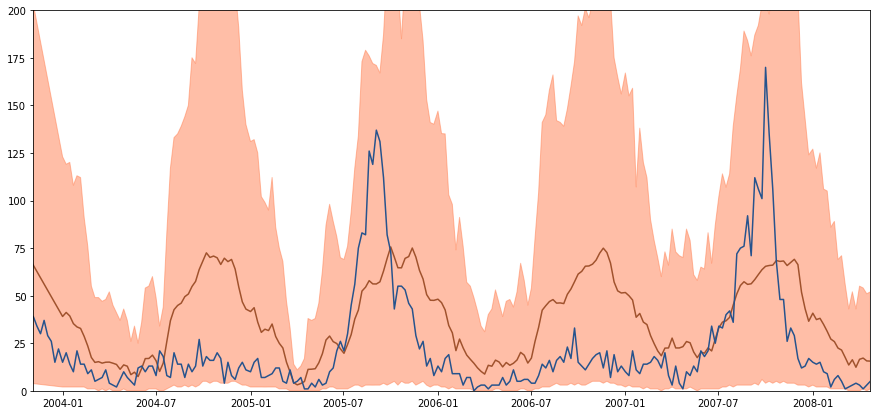

In [407]:
plt.plot(forecast.ds, forecast.yhat, color='sienna')
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, edgecolor='coral', facecolor='coral', alpha=0.5)
plt.plot(sj_train_test.index, sj_train_test.total_cases, color='#26538D')
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

In [408]:
model_classification(sj_train_test.dropna().total_cases, pd.Series(pred.yhat))

--------------------
RMSE: 29.93
--------------------
MAE: 23.79
Explained variance: 0.214
--------------------


## Facebook Prophet (logged)

In [685]:
from prophet import Prophet

In [686]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(3)
    .index
)

In [687]:
prophet_df = pd.DataFrame(np.log(sj_train_train.dropna().total_cases + 1)).reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = pd.concat([prophet_df, sj_train_train.dropna()[my_features].reset_index(drop=True)], axis=1)
# prophet_df['cap'] = 3 * prophet_df['y'].max()
prophet_df.head()

ds         y  station_min_temp_c_lag7  station_min_temp_c_lag8  \
0 1990-07-30  2.890372                     23.3                     23.9   
1 1990-08-06  3.178054                     22.8                     23.3   
2 1990-08-13  2.639057                     22.8                     22.8   
3 1990-08-20  3.091042                     24.4                     22.8   
4 1990-08-27  3.367296                     21.7                     24.4   

   station_avg_temp_c_lag8  
0                28.114286  
1                27.414286  
2                28.371429  
3                28.328571  
4                28.328571

In [699]:
m = Prophet(interval_width=0.95,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=0.001,
#             mcmc_samples=1000,
#             likelihood='NegBinomial',
            growth='flat',
            yearly_seasonality=True)

In [700]:
for i in range(len(sj_train_train[my_features].columns)):
    m.add_regressor(sj_train_train[my_features].iloc[:,i].name)

In [701]:
# m.extra_regressors

In [702]:
model = m.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.6224
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       987.093   2.60954e-05      0.992909           1           1       65   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [703]:
sj_train = pd.concat([sj_train_train, sj_train_test])
sj_train = sj_train[my_features].dropna().reset_index()
sj_train = sj_train.rename(columns={'index': 'ds'})

In [704]:
forecast = m.predict(sj_train)

This `clips` the possible values, so that there are no negative values (we have count values as the target!!!)

In [705]:
# for col in ['yhat', 'yhat_lower', 'yhat_upper']:
#     forecast[col] = forecast[col].clip(lower=0.0)

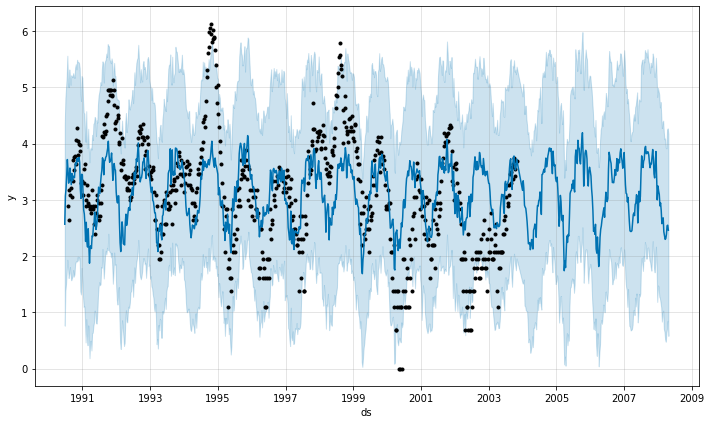

In [706]:
m.plot(forecast);

In [707]:
pred = pd.DataFrame(forecast[['yhat', 'ds']])
pred.index = pred.ds
pred = pred.drop('ds', axis=1)
pred = pred.loc[sj_train_test.dropna().index[0]:]
pred.yhat = np.exp(pred.yhat)
pred.yhat -=1

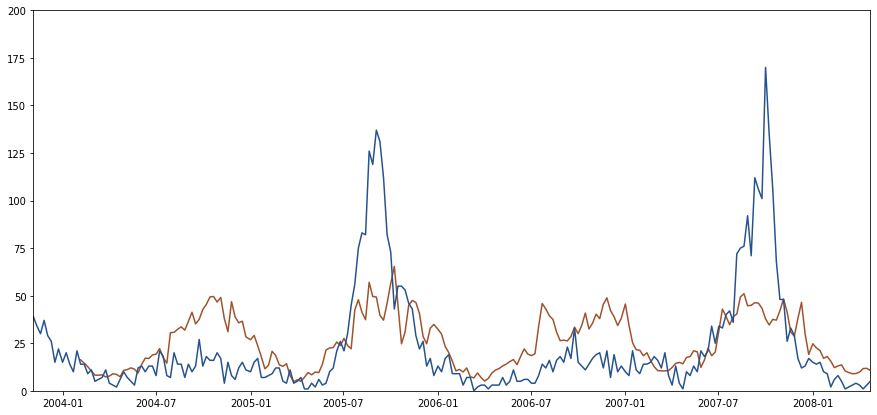

In [708]:
plt.plot(pred.index, pred.yhat, color='sienna')
plt.plot(sj_train_test.index, sj_train_test.total_cases, color='#26538D')
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

In [709]:
model_classification(sj_train_test.dropna().total_cases, pd.Series(pred.yhat))

--------------------
RMSE: 24.41
--------------------
MAE: 15.97
Explained variance: 0.319
--------------------
